# Pitchers

Now that I have my tables cleaned, combined and ready for analysis it's time to get a better understanding of the data and make any final changes to remove outliers or unnecessary columns. This notebook will be solely focused on pitchers, I will have a separate notebook for the batters that will follow along a very similar process to this one.

## Data Preparation

In [1]:
# Import necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition, svm
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

/Users/derekdavis/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/Users/derekdavis/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


To better organize my notebook I have stored all of the functions I will be using throughout in this next cell of code.

In [2]:
# Visualize the impact of a few key metrics on Hall of Fame inclusivity 
def comparative_graph(s):
    cat, num = 'inducted', s
    fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False, figsize=(20, 7))
    fig.suptitle(s + ' vs Inducted', fontsize=20)

    # Create a distribution graph to compare HOF inducted players against those not inducted by a certain metric.
    ax[0].title.set_text('density')
    for i in df[cat].unique():
        sns.distplot(df[df[cat]==i][num], hist=False, label=i, ax=ax[0])
    ax[0].grid(True)
    
    # Create a stacked bar graph containing 10 bins to help visualize the divide between the two classes of players.
    ax[1].title.set_text('bins')
    breaks = np.quantile(df[num], q=np.linspace(0,1,11))
    tmp = df.groupby([cat, pd.cut(df[num], breaks, duplicates='drop')]).size().unstack().T
    tmp = tmp[df[cat].unique()]
    tmp["tot"] = tmp.sum(axis=1)
    for col in tmp.drop("tot", axis=1).columns:
         tmp[col] = tmp[col] / tmp["tot"]
    tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
    
    # Create a boxplot to compare HOF inducted players against those not inducted and to visualize outliers.   
    ax[2].title.set_text('outliers')
    sns.boxplot(x=cat, y=num, data=df, ax=ax[2])
    ax[2].grid(True)
    plt.show()

    
# Create a new correlated dataframe with absolute value of a number,
def high_corr(df):
    df_highcorr = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    df_highcorr['Highly Correlated Pairs'] = list(zip(df_highcorr.level_0, df_highcorr.level_1))
    df_highcorr.set_index(['Highly Correlated Pairs'], inplace = True)
    df_highcorr.drop(columns=['level_1', 'level_0'], inplace = True)
    df_highcorr.columns = ['Correlation']
    df_highcorr.drop_duplicates(inplace=True)
    return df_highcorr[(df_highcorr.Correlation>.7) & (df_highcorr.Correlation<1)]
    
# Create function used to find Precision, Recall, Accuracy, and F1 Scores.
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
# Find the optimal K value for KNN models.
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k 
            best_score = f1
            
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

# Create a function that visualizes the confusion matrix for the model.    
def plot_cm(model):
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.grid(False)
    plot_confusion_matrix(model, X_test, y_test, cmap='Greens', ax=ax)
    fig.savefig('confusion_matrix.png')
    
def log_transform(df,features):
    '''Runs a log transformation on a feature
    
        @params
        df is a pd.Dataframe
        features is a list of columns to be considered
        
        @output
        new log-transformed column
    
    '''
    for feature in features:
        df[feature + '_log'] = np.log(df[feature]+1)
    return df
    

In [3]:
#Import eligible_pitchers from cleaning notebook
pitchers_df = pd.read_csv('eligible_pitchers.csv')
pitchers_df['inducted'] = pitchers_df['inducted'].apply(lambda x: 1 if x == 'Y' else 0) # numerical boolean
pitchers_df

,playerID,Seasons,fullName,W,L,G,GS,CG,SHO,SV,...,FP,Cy Young,Gold Glove,Hank Aaron,Most Valuable Player,Rolaids Relief Man Award,Rookie of the Year,Silver Slugger,ASG,inducted
0,aasedo01,13,Don Aase,66,60,448,91,22,5,82,...,0.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,abbotgl01,12,Glenn Abbott,62,83,248,206,37,5,0,...,0.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,abbotji01,11,Jim Abbott,87,108,263,254,31,6,0,...,0.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,abbotpa01,12,Paul Abbott,43,37,162,112,1,0,0,...,0.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,abernte02,17,Ted Abernathy,63,69,681,34,7,2,148,...,0.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,zahnge01,14,Geoff Zahn,111,109,304,270,79,20,1,...,0.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1338,zambrca01,12,Carlos Zambrano,132,91,354,302,10,5,0,...,0.95,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0
1339,zoldasa01,10,Sam Zoldak,43,53,250,93,30,5,8,...,0.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1340,zuberbi01,12,Bill Zuber,43,42,224,65,23,3,6,...,0.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
# View all the columns in the DataFrame.
list(pitchers_df)

['playerID',
 'Seasons',
 'fullName',
 'W',
 'L',
 'G',
 'GS',
 'CG',
 'SHO',
 'SV',
 'IPouts',
 'H',
 'ER',
 'HR',
 'BB',
 'SO',
 'R',
 'IP',
 'ERA',
 'WHIP',
 'K/9',
 'K/BB',
 'BAA',
 'Position',
 'PO',
 'A',
 'E',
 'FP',
 'Cy Young',
 'Gold Glove',
 'Hank Aaron',
 'Most Valuable Player',
 'Rolaids Relief Man Award',
 'Rookie of the Year',
 'Silver Slugger',
 'ASG',
 'inducted']

One of the first things that I want to consider is how the Steroids Era in baseball, a period from 1993-2002, might impact our analysis. There are several players who on paper would be first ballot Hall of Famers; however, due to steroid use have failed to recieve enough votes. This will have a much bigger impact on the batters in our other model, but there is one pitcher, Roger Clemens who is considered one of the best of all time that has been left out due to steroids use. This would be an outlier that would skew the results for some of the models and for that reason will be removed. I am also going to remove Babe Ruth from this list as he was elected to the HOF based on this performances as a hitter but he pitch for several years, albeit at a high level still not enough to be elected as a pitcher.

In [5]:
# Remove Roger Clemens and Babe Ruth from the DataFrame.
pitchers_df = pitchers_df[(pitchers_df['fullName']!='Roger Clemens') & (pitchers_df['fullName']!='Babe Ruth')]

In [6]:
# Drop unnecessary columns.
df = pitchers_df.drop(columns=['playerID', 'fullName', 'Position', 'Hank Aaron', 'Silver Slugger'])

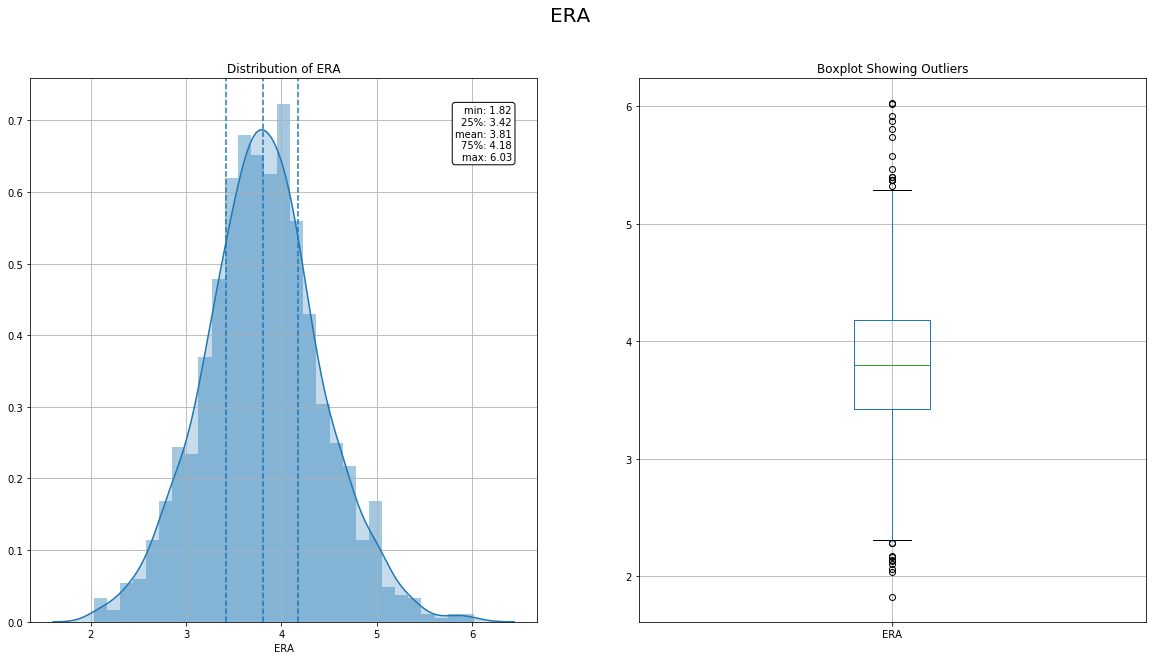

In [7]:
# Create two graphs, a Distribution and Boxplot comparing ERA across all pitchers.
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False, figsize=(20,10))
fig.suptitle('ERA', fontsize=20)

# Create Distribution Showing ERA across all eligible for the HOF
ax[0].title.set_text('Distribution of ERA')
variable = df['ERA']
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = df['ERA'].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

# Create a Boxplot showing Outliers.
ax[1].title.set_text('Boxplot Showing Outliers')
df.boxplot(column='ERA', ax=ax[1])
plt.show()

Now I am going to look at a few of the other key metrics and analyze them with our comparative graph function I created earlier. This will show us how those elected to the Hall of Fame compare to those who were not. Keep in mind, that all players in this analysis have played for 10 years or more suggesting that even those not elected have had very successful careers.

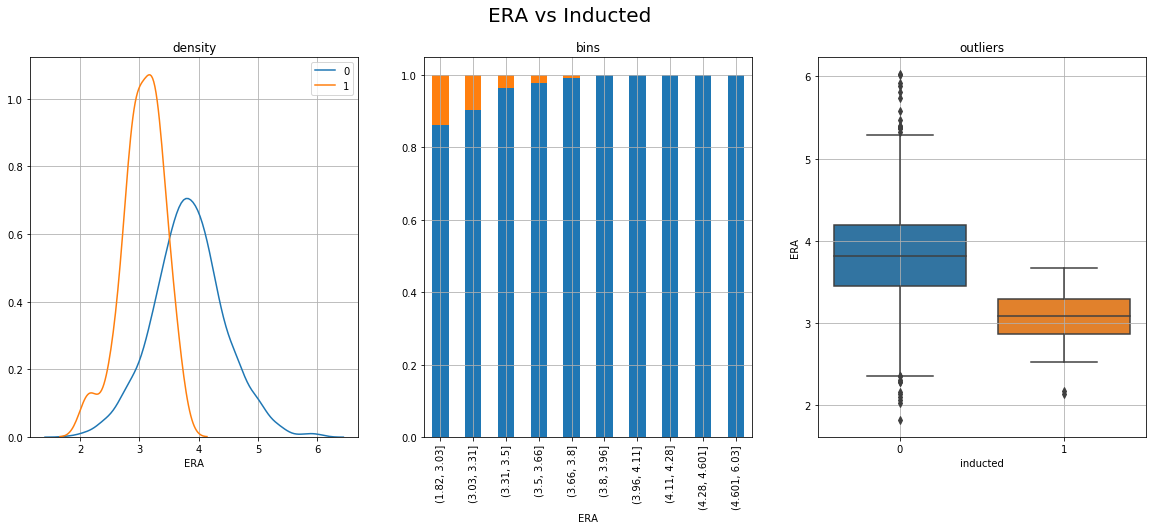

In [8]:
# First take a look at ERA.
comparative_graph('ERA')

You can see that the average ERA for those not in the Hall of Fame tends to hover just below 4, while those elected is right around 3. This is a great example of how fine a margin it is between a really good player and an elite player. It also goes to show just how important one run often is in baseball!

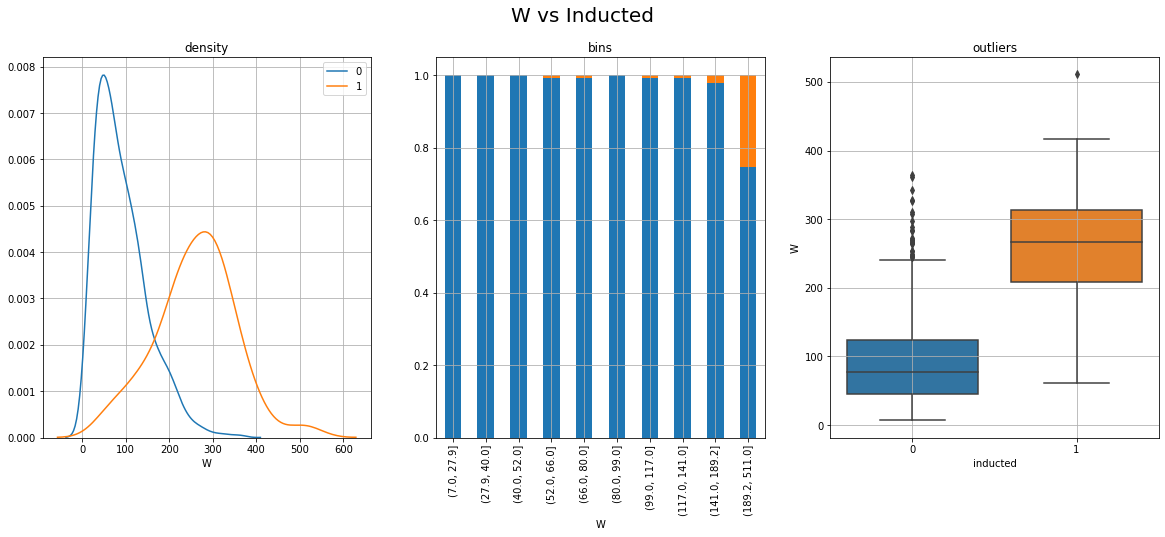

In [9]:
# Now analyze the difference in wins between the two sets of players.
comparative_graph('W')

Unlike ERA where the difference was less than one run per game allow, the average number of wins for a Hall of Fame pitchers greatly exceeds that of a non-inductee. This is an interesting statistic that I would project to see a lot of change over the next years and decades. In the early days of baseball it was reasonable for a pitcher to start 40-50 games a year, now that there is a better understanding of load management and its impact on injuries it is unlikely for any pitcher to start more than 34 or 35 games a season. This could see a rise in winning percentage as a key comparison metric over X number of seasons rather than total wins. For now it's still very useful.

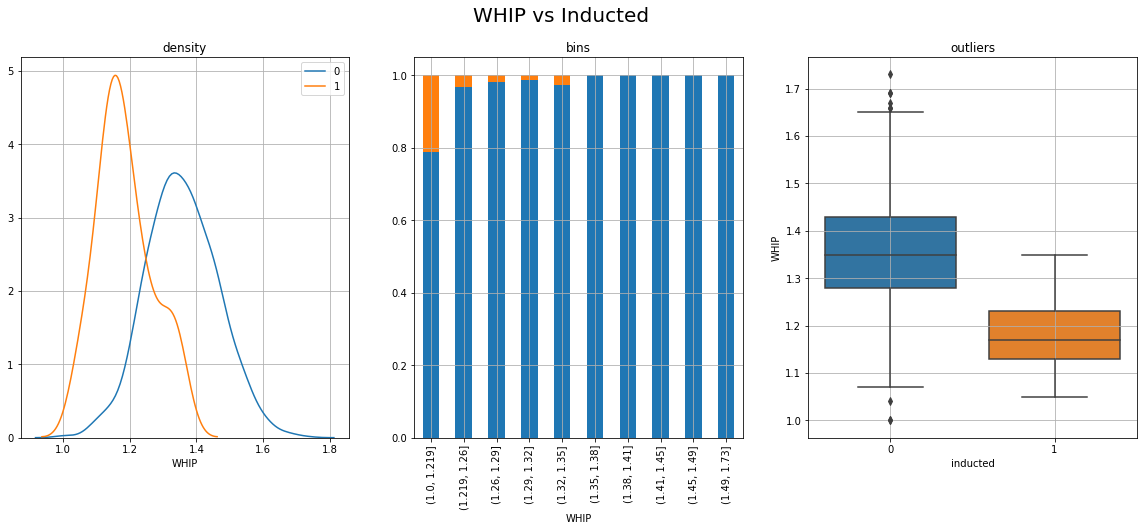

In [10]:
# Visualize a WHIP comparison.
comparative_graph('WHIP')

WHIP, which stands for walks and hits per inning pitched is a great tool for showing a pitchers ability to keep hitters off base. The fewer runners allowed on base, the fewer runs that will be allowed and therefore you could assume more wins. As we can see most of these features are intertwined which could later have an impact on our models due to multicollinearity.

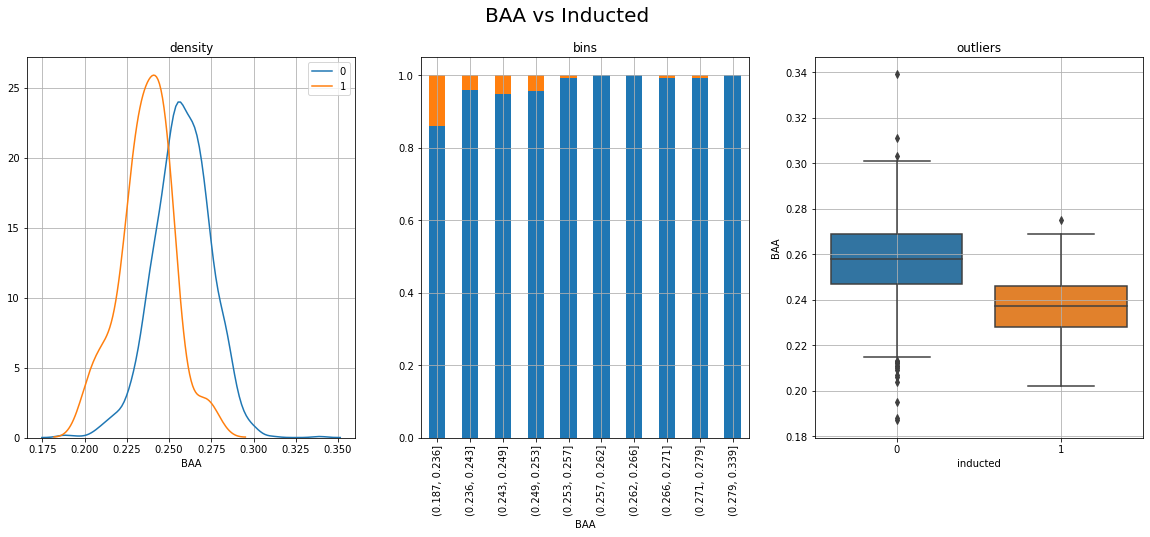

In [11]:
# Visualize BAA between the two sets of pitchers.
comparative_graph('BAA')

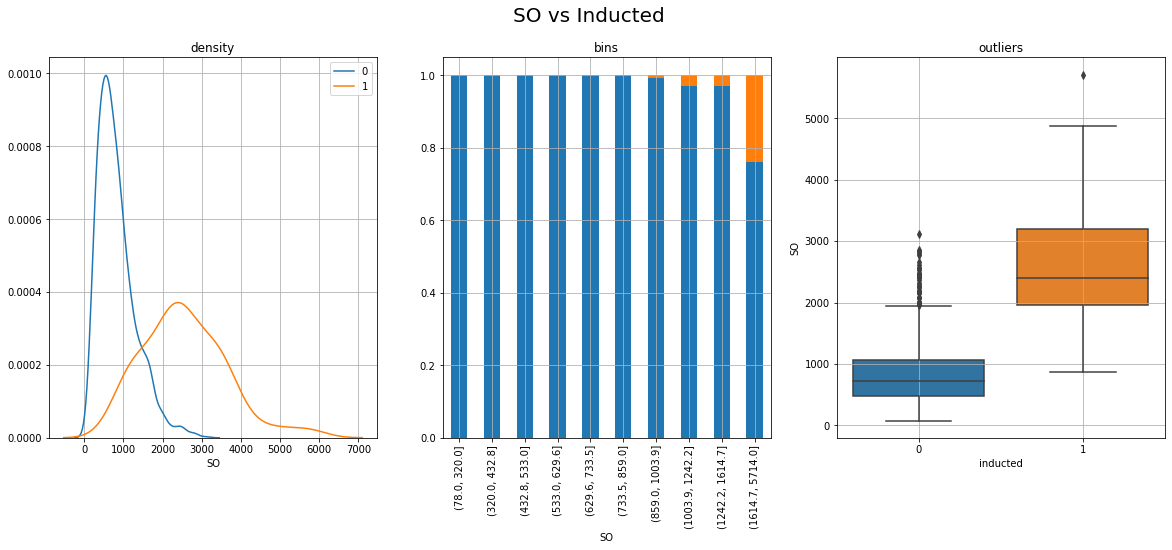

In [12]:
# Look at the comparison of strikeouts.
comparative_graph('SO')

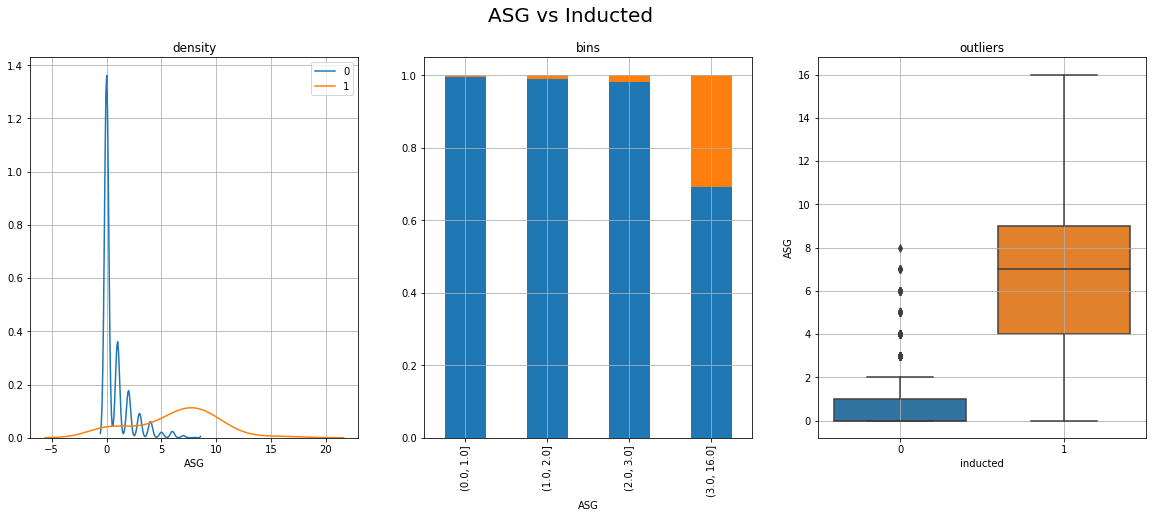

In [13]:
# Finally, let's see how All-Star appearances can be an indicator.
comparative_graph('ASG')

Although we have several other features that we could look into, those are the six we are going to stick to at the moment. It's pretty clear from the visualizations above that each of these metrics impact Hall of Fame candidancy to a certain degree, I'll determine later the importance of each feature.

Now I want to understand which features are highly correlated and could possibly lead to multicollinearity issues in any of the models.

In [14]:
# Create a heatmap showing the correlation between features.
def heatmap(d):
    plt.figure(figsize=(20, 10))
    heatmap = sns.heatmap(d.corr(), vmin=-1, vmax=1, annot=True)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

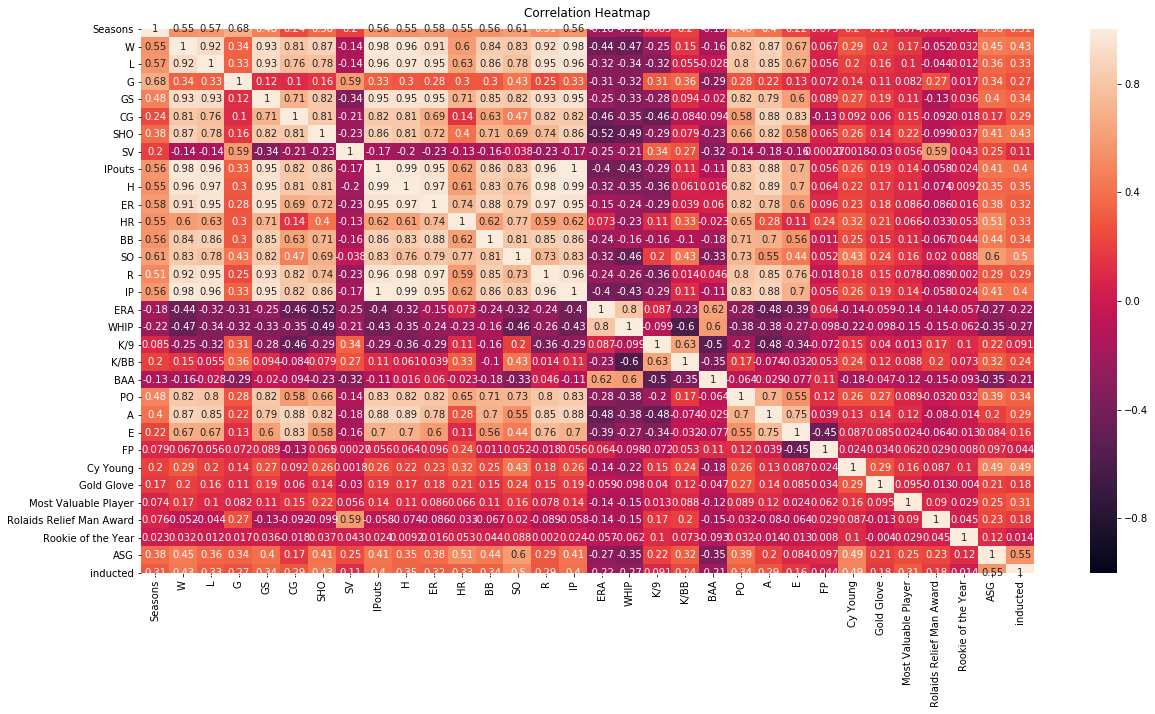

In [15]:
heatmap(df)

In [16]:
# Run high_corr function to determine highly correlated features.
high_corr(df)

,Correlation
Highly Correlated Pairs,
"(IP, IPouts)",1.000000
"(IP, H)",0.987632
"(H, IPouts)",0.987632
"(IP, W)",0.983416
"(W, IPouts)",0.983416
...,...
"(ER, SHO)",0.721168
"(PO, BB)",0.711039
"(HR, GS)",0.710602


In [17]:
# Drop columns that are highly correlated.
df = df.drop(columns=['IPouts', 'H', 'R', 'L', 'ER', 'PO', 'BB', 'HR', 'GS', 'A', 'E', 'IP', 'SHO', 'CG'], axis=1)

In [18]:
high_corr(df)

,Correlation
Highly Correlated Pairs,
"(W, SO)",0.827684
"(ERA, WHIP)",0.799456


In [19]:
# View remaing columns.
df.columns

Index(['Seasons', 'W', 'G', 'SV', 'SO', 'ERA', 'WHIP', 'K/9', 'K/BB', 'BAA',
       'FP', 'Cy Young', 'Gold Glove', 'Most Valuable Player',
       'Rolaids Relief Man Award', 'Rookie of the Year', 'ASG', 'inducted'],
      dtype='object')

# Models

Now I want to start creating a few different models to determine which is best for our data. I am going to first look at what the accuracy of our model would be if it simply classified everyone as a non-inductee. This number should be fairly high as it's am extremely selective process. From there I will build a basic Logisitic Regression model, a KNN model, a SVM model and finally a Decision Tree and Random Forest model.

In [20]:
# Look at the summary statistics for target variable.
print(df['inducted'].describe())
print('-'*30)

# What is the percentage of people who have been inducted from this dataset?
print("Mean percentage: " + str(round(np.mean(df['inducted']*100), 3)))

count    1340.000000
mean        0.030597
std         0.172288
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: inducted, dtype: float64
------------------------------
Mean percentage: 3.06


As we can see, even if we simply marked everyone as a non-inductee we would still almost have 97% accuracy. For this project we should hope to see in the range of 98.5% to 99.5% accuracy to deem it successful.

In [21]:
# Split the data.
y = df['inducted']
X = df.drop(columns=['inducted'], axis=1)

# Train the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42)

# Print the info.
print("X_train shape:", X_train.shape, "| X_test shape:", X_test.shape)
print("y_train mean:", round(np.mean(y_train),2), "| y_test mean:", round(np.mean(y_test),2))
print(X_train.shape[1], "features:", X_train.columns.to_list())

X_train shape: (938, 17) | X_test shape: (402, 17)
y_train mean: 0.03 | y_test mean: 0.04
17 features: ['Seasons', 'W', 'G', 'SV', 'SO', 'ERA', 'WHIP', 'K/9', 'K/BB', 'BAA', 'FP', 'Cy Young', 'Gold Glove', 'Most Valuable Player', 'Rolaids Relief Man Award', 'Rookie of the Year', 'ASG']


# Logistic Regression

The first model I am going to explore is logisitic regression. The variables are all continuous which works well for logistic regression, it should be expected that this is one of the more accurate models.

In [22]:
# Instantiate
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

# Fit the model to training data
model_log = logreg.fit(X_train, y_train)

# Predict on test set
y_hat_test = logreg.predict(X_test)

In [23]:
from sklearn.metrics import roc_curve, auc

# Calculate the probability scores of each point in the training set
y_train_score = model_log.decision_function(X_train)

# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

# Calculate the probability scores of each point in the test set
y_score = model_log.decision_function(X_test)

# Calculate the fpr, tpr, and thresholds for the test set
fpr, tpr, thresholds = roc_curve(y_test, y_score)

AUC: 0.9933898614150255


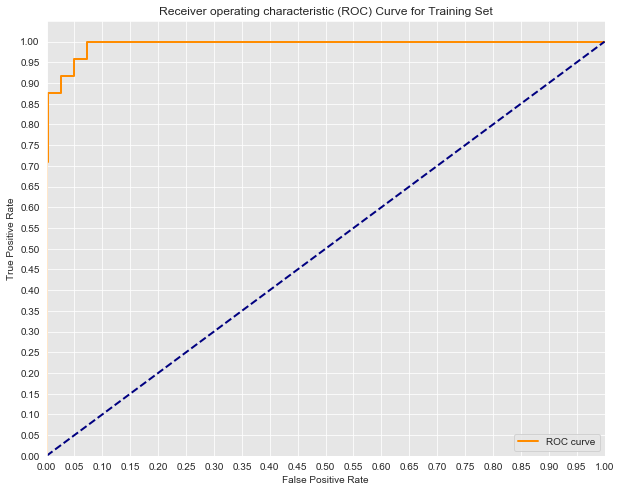

In [24]:
# Use Seaborn to Plot AUC.
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# ROC curve for training set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
print('AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.show()

In [25]:
# Training accuracy score
logreg.score(X_train, y_train)

0.9925373134328358

Test AUC: 0.9935828877005347



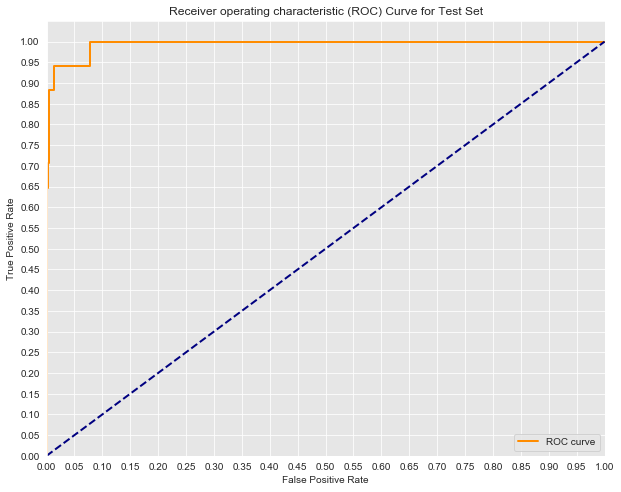

In [26]:
# ROC curve for test set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
print('Test AUC: {}'.format(auc(fpr, tpr)))
print('')
plt.show()

In [27]:
# Testing Accuracy Score
logreg.score(X_test, y_test)

0.9875621890547264

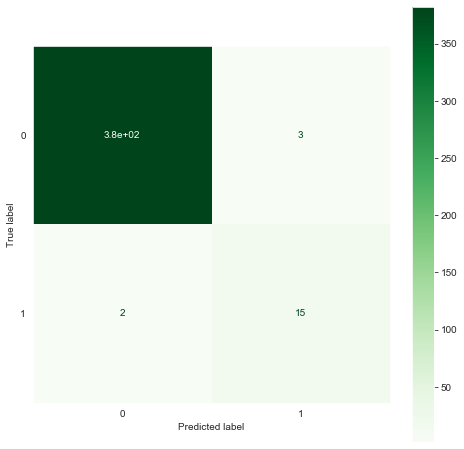

In [28]:
# Plot the confusion matrix.
plot_cm(logreg)

Just as expected this model worked fairly well on both the training and test set. With an area under the curve of 99.4% on the training data and 99.43% on the test data as well as an accuracy score of 99.25% on the training data and 98.76% on test data (Only 5 players were misclassified). Another thing to consider is that logistic regression is not very tolerant of multicollinearity which shouldn't be playing a role in these results as most of the highly correlated variables have been removed. One thing to consider is that our model has moderate class imbalance. I am going to use SMOTE to synthetically create balance by adding to our underrepresented class, which is Hall of Famers.

## Logistic Regression with SMOTE

In [29]:
# Previous original class distribution
print(y_train.value_counts())

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

0    914
1     24
Name: inducted, dtype: int64


1    914
0    914
dtype: int64


In [30]:
# Instantiate
logreg_smote = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

# Fit the model to training data
model_log_smote = logreg_smote.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_hat_test = logreg_smote.predict(X_test)

In [31]:
# Calculate the probability scores of each point in the training set
y_train_score = model_log.decision_function(X_train_resampled)

# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train_resampled, y_train_score)

# Calculate the probability scores of each point in the test set
y_score = model_log_smote.decision_function(X_test)

# Calculate the fpr, tpr, and thresholds for the test set
fpr, tpr, thresholds = roc_curve(y_test, y_score)

AUC: 0.9954751997854909


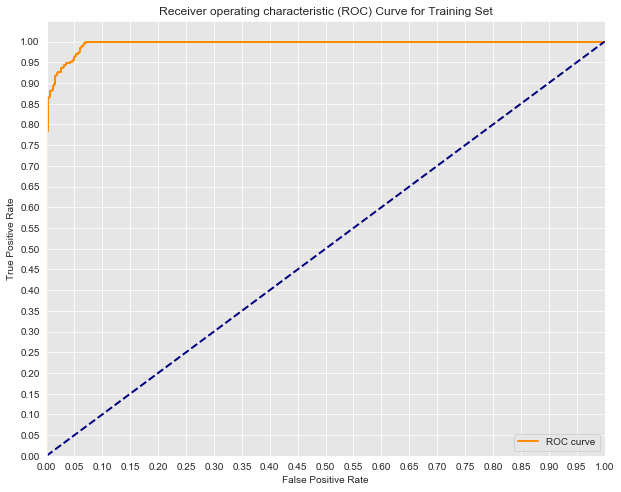

In [32]:
# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# ROC curve for training set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
print('AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.show()

In [33]:
# Training accuracy score
logreg_smote.score(X_train_resampled, y_train_resampled)

0.9846827133479212

Test AUC: 0.9928189457601222



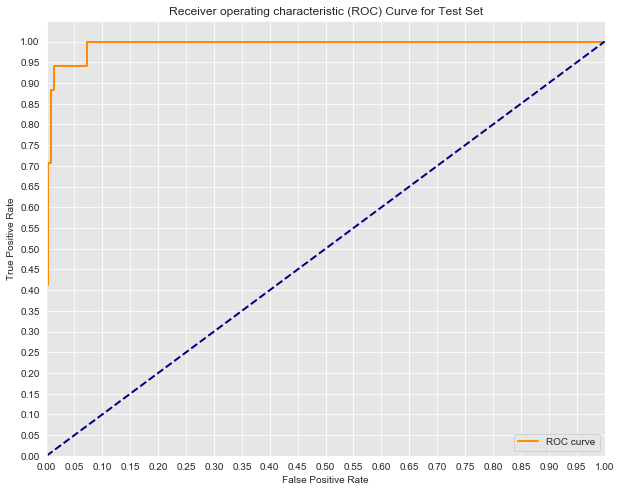

In [34]:
# ROC curve for test set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
print('Test AUC: {}'.format(auc(fpr, tpr)))
print('')
plt.show()

In [35]:
# Training accuracy score
logreg_smote.score(X_test, y_test)

0.9651741293532339

As we can see, there was a significant decrease in the accuracy of both our training and test analysis when we used SMOTE to balance the classes. Therefore, I will not utilize that in my logistic regression model. The last thing I want to do to boost the models performance is find the best hyperparameters using GridSearchCV.

## Hyperparameter for Logistic Regression

In [36]:
model = LogisticRegression()

log_param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'C': [100, 10, 1.0, 0.1, 0.01, 1e12],
    'class_weight': [None, 'balanced'],
    'max_iter': [10000],
    'fit_intercept': [False] }

# define grid search
grid_log = GridSearchCV(model, log_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_log.fit(X_train, y_train)

best_parameters = grid_log.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds_log = grid_log.predict(X_train)
test_preds_log = grid_log.predict(X_test)
training_accuracy_log = accuracy_score(y_train, training_preds_log)
test_accuracy_log = accuracy_score(y_test, test_preds_log)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy_log * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy_log * 100))

Grid Search found the following optimal parameters: 
C: 0.1
class_weight: None
fit_intercept: False
max_iter: 10000
penalty: 'l2'
solver: 'newton-cg'

Training Accuracy: 98.93%
Testing Accuracy: 99.0%


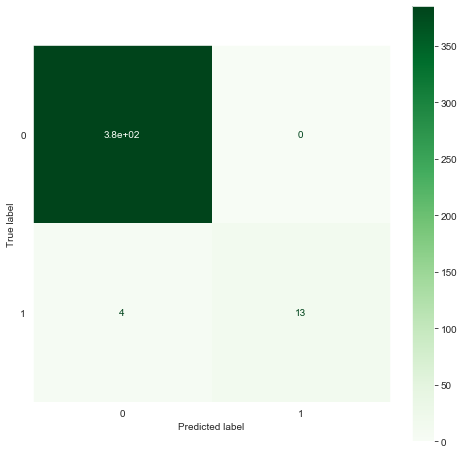

In [37]:
plot_cm(grid_log)

In [38]:
# View the metrics.
print_metrics(y_test, test_preds_log)

Precision Score: 1.0
Recall Score: 0.7647058823529411
Accuracy Score: 0.9900497512437811
F1 Score: 0.8666666666666666


The model was able to accurately predict one more value after tuning to find the best hyperparameters. Our training score did slightly decrease but an increase in test score suggests that this model has no problem with overfitting. One thing to consider moving forward is the importance of recall vs precision. As we can see, there is a perfect precision score associated with this model but our recall score of 76.47% could be an issue if false negatives are deemed more damaging to the models credibility.

# K-Nearest Neighbors

Although my variables are all continuous and KNN works best for categorical features for arguments sake I am going to create this type of model as well. First I'll start by scaling all of the features as this is necessary in this type of analysis then I'll use the find_best_k function from above to determine the parameters. Finally, using the print_metrics function from above I will identify the precision, recall, accuracy and F1 score for this model.

In [39]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_data_train, columns=X.columns)
scaled_df_train.head()

,Seasons,W,G,SV,SO,ERA,WHIP,K/9,K/BB,BAA,FP,Cy Young,Gold Glove,Most Valuable Player,Rolaids Relief Man Award,Rookie of the Year,ASG
0,-1.108774,-1.185416,-0.948020,-0.530921,-0.938561,1.547419,0.980214,0.781775,-0.137204,0.089580,-2.160777,-0.170342,-0.096849,-0.092748,-0.133787,-0.123091,-0.519511
1,-0.541845,-0.794313,-0.582870,-0.018214,-0.335969,-0.323682,-0.208166,1.185819,0.239262,-1.223327,0.752501,-0.170342,-0.096849,-0.092748,-0.133787,-0.123091,-0.519511
2,1.725867,2.394679,1.450739,-0.067831,1.047893,-1.075321,-0.482408,-1.124628,-0.800502,-0.081669,-0.079864,-0.170342,-0.096849,-0.092748,-0.133787,-0.123091,-0.519511
3,-0.825309,-0.267829,-0.689606,-0.415149,-0.726603,-0.275706,-0.116753,-1.130319,-1.069407,0.432078,1.168683,-0.170342,-0.096849,-0.092748,-0.133787,-0.123091,-0.519511
4,-0.258381,-0.929695,-0.908696,-0.051292,-1.001623,0.395972,1.711526,-0.384830,-1.176969,0.374995,0.336318,-0.170342,-0.096849,-0.092748,-0.133787,-0.123091,-0.519511


In [40]:
find_best_k(scaled_data_train, y_train, scaled_data_test, y_test)

Best Value for k: 3
F1-Score: 0.5161290322580646


In [41]:
# Instantiate KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=3)

# Fit the classifier
clf_knn.fit(scaled_data_train, y_train)

# Predict on the test set
test_preds = clf_knn.predict(scaled_data_test)

In [42]:
print_metrics(y_test, test_preds)

Precision Score: 0.5714285714285714
Recall Score: 0.47058823529411764
Accuracy Score: 0.9626865671641791
F1 Score: 0.5161290322580646


As I assumed earlier, this model did not work very well. The accuracy score and precision score is relatively high but a low recall suggest that there are a lot of false negatives which in this case means Hall of Famers that were classified as not. We saw earlied that our accuracy would be just below 97% if we classifed every player as a non-inductee, this model did slightly better but not nearly as well as our logistic regression model.

## KNN with SMOTE

I am going to see if SMOTE will have a positive impact on the KNN model.

In [43]:
# Previous original class distribution
print(y_train.value_counts())

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

0    914
1     24
Name: inducted, dtype: int64


1    914
0    914
dtype: int64


In [44]:
# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train_resampled)
scaled_data_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_data_train, columns=X.columns)
scaled_df_train.head()

,Seasons,W,G,SV,SO,ERA,WHIP,K/9,K/BB,BAA,FP,Cy Young,Gold Glove,Most Valuable Player,Rolaids Relief Man Award,Rookie of the Year,ASG
0,-1.453341,-1.484885,-1.444890,-0.602766,-1.248478,2.204512,1.555825,0.759856,-0.572058,0.552140,-2.987770,-0.58357,-0.269307,-0.389067,-0.261901,-0.175216,-0.972351
1,-1.041197,-1.248496,-1.126712,-0.146173,-0.921920,0.221651,0.389608,1.220418,-0.209538,-0.799831,0.704822,-0.58357,-0.269307,-0.389067,-0.261901,-0.175216,-0.972351
2,0.607381,0.678978,0.645292,-0.190360,-0.171975,-0.574883,0.120481,-1.413215,-1.210784,0.375796,-0.350205,-0.58357,-0.269307,-0.389067,-0.261901,-0.175216,-0.972351
3,-1.247269,-0.930281,-1.219718,-0.499665,-1.133613,0.272493,0.479317,-1.419702,-1.469727,0.904829,1.232335,-0.58357,-0.269307,-0.389067,-0.261901,-0.175216,-0.972351
4,-0.835125,-1.330323,-1.410624,-0.175631,-1.282653,0.984290,2.273498,-0.569934,-1.573304,0.846047,0.177308,-0.58357,-0.269307,-0.389067,-0.261901,-0.175216,-0.972351


In [45]:
find_best_k(scaled_data_train, y_train_resampled, scaled_data_test, y_test)

Best Value for k: 1
F1-Score: 0.6666666666666667


In [46]:
# Instantiate KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)

# Fit the classifier
clf.fit(scaled_data_train, y_train_resampled)

# Predict on the test set
test_preds = clf.predict(scaled_data_test)

In [47]:
print_metrics(y_test, test_preds)

Precision Score: 0.4827586206896552
Recall Score: 0.8235294117647058
Accuracy Score: 0.9552238805970149
F1 Score: 0.608695652173913


Unfortunately, this did not perform well either. This time we have a low precision score which simply suggests the opposite, a high number of non-inductees classified as Hall of Famers. It was a good attempt, but KNN is not the right model for this dataset.

# Support Vector Machines

Another model type that would be useful to test is support vector machines. I will compare a basic SVM to one where the data is standarized to see which offers better results. Additionally, there are a few hyperparameters, kernel perhaps being the most important, to test.  

In [48]:
# Create a SVM model where we can test different kernels.
def svm(k):    
    base_svc = SVC(kernel=k)

    base_svc.fit(X_train, y_train)
    svc_prediction_train = base_svc.predict(X_train)
    svc_prediction_test = base_svc.predict(X_test)

    print('Training Accuracy Score:')
    print(accuracy_score(y_train, svc_prediction_train))

    print('Testing Accuracy Score:')
    print(accuracy_score(y_test, svc_prediction_test))
    print('-'*30)

In [49]:
# Standardize the data
std = StandardScaler()
X_train_transformed = std.fit_transform(X_train)
X_test_transformed = std.transform(X_test)

In [50]:
def svm_tran(k):    
    base_svc = SVC(kernel=k)

    base_svc.fit(X_train_transformed, y_train)
    svc_prediction_train = base_svc.predict(X_train_transformed)
    svc_prediction_test = base_svc.predict(X_test_transformed)

    print('Training Accuracy Score:')
    print(accuracy_score(y_train, svc_prediction_train))

    print('Testing Accuracy Score:')
    print(accuracy_score(y_test, svc_prediction_test))
    print('-'*30)

In [51]:
# Compare SVM and SVM_tran for kernel equal to rbf.
svm('rbf')
svm_tran('rbf')

Training Accuracy Score:
0.9808102345415778
Testing Accuracy Score:
0.9676616915422885
------------------------------
Training Accuracy Score:
0.9936034115138592
Testing Accuracy Score:
0.9626865671641791
------------------------------


In [52]:
# Compare SVM and SVM_tran for kernel equal to linear.
svm('linear')
svm_tran('linear')

Training Accuracy Score:
0.9925373134328358
Testing Accuracy Score:
0.9925373134328358
------------------------------
Training Accuracy Score:
0.9925373134328358
Testing Accuracy Score:
0.9900497512437811
------------------------------


In [53]:
# Compare SVM and SVM_tran for kernel equal to sigmoid.
svm('sigmoid')
svm_tran('sigmoid')

Training Accuracy Score:
0.9744136460554371
Testing Accuracy Score:
0.9577114427860697
------------------------------
Training Accuracy Score:
0.9637526652452025
Testing Accuracy Score:
0.9402985074626866
------------------------------


We will replicate the base SVM adding degree as an input as is necessary for testing the polynomial kernel.

In [54]:
base_svc = SVC(kernel='poly', degree=1)

base_svc.fit(X_train, y_train)
svc_prediction_train = base_svc.predict(X_train)
svc_prediction_test = base_svc.predict(X_test)

print('Training Accuracy Score:')
print(accuracy_score(y_train, svc_prediction_train))

print('Testing Accuracy Score:')
print(accuracy_score(y_test, svc_prediction_test))
print('-'*30)

Training Accuracy Score:
0.9829424307036247
Testing Accuracy Score:
0.972636815920398
------------------------------


In [55]:
base_svc1 = SVC(kernel='poly', degree=1)

base_svc1.fit(X_train_transformed, y_train)
svc_prediction_train1 = base_svc1.predict(X_train_transformed)
svc_prediction_test1 = base_svc.predict(X_test_transformed)

print('Training Accuracy Score:')
print(accuracy_score(y_train, svc_prediction_train1))

print('Testing Accuracy Score:')
print(accuracy_score(y_test, svc_prediction_test1))
print('-'*30)

Training Accuracy Score:
0.9914712153518124
Testing Accuracy Score:
0.9577114427860697
------------------------------


The linear model that was not standardized performed the best by a significant margin. With a training and test score of 99.25% accuracy this is the best model up to this point. I am going to test several other hyperparameters to determine if it's possible to improve our baseline model.

*Note when the degree for poly kernel was increased, the accuracy went down and the run time greatly increased. With that considered I will only use linear, rbf and sigmoid in the following hyperparameter search.

## Hyperparameter for SVM

Here I will utilize GridSearchCV to find the optimal hyperparameters and try to improve on our exisiting model. 

In [110]:
model = SVC()
kernel = ['linear']
C = [.0001, .001, .01, 1]
gamma = [.001, .01, 1]
grid = dict(kernel=kernel,C=C,gamma=gamma)
grid_svc = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_svc.fit(X_train, y_train)

best_parameters = grid_svc.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds_svc = grid_svc.predict(X_train)
test_preds_svc = grid_svc.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds_svc)
test_accuracy = accuracy_score(y_test, test_preds_svc)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
C: 1
gamma: 0.001
kernel: 'linear'

Training Accuracy: 99.25%
Testing Accuracy: 99.25%


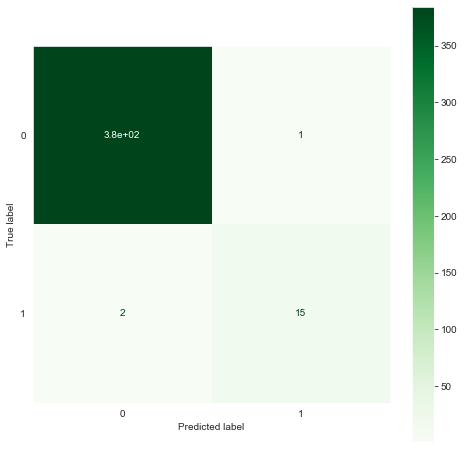

In [111]:
plot_cm(grid_svc)

In [113]:
print_metrics(y_test, test_preds_svc)

Precision Score: 0.9375
Recall Score: 0.8823529411764706
Accuracy Score: 0.9925373134328358
F1 Score: 0.9090909090909091


The optimized SVM model matches that of the base linear model in terms of both training and testing accuracy. This model correctly classified all but 3 players and performed well both in terms of precision score and recall score. As mentioned earlier, I will determine which of those scores holds more weight in this analysis but that will come later in the analysis.

# Decision Trees

Now that I have built a few models, some with great success and others that have been slightly lacking I want to look to see if any type of Tree model could improve on the accuracy. Since all of our features are continuous, there is a good chance that the previous models will outperform the following but it'll be interesting to compare the results.

In [59]:
# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [60]:
# Test set predictions
dt_pred = tree_clf.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, dt_pred))
print(classification_report(y_test, dt_pred))

[[381   4]
 [  6  11]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       385
           1       0.73      0.65      0.69        17

    accuracy                           0.98       402
   macro avg       0.86      0.82      0.84       402
weighted avg       0.97      0.98      0.97       402



In [61]:
tree_clf.score(X_train, y_train)

0.9968017057569296

In [62]:
tree_clf.score(X_test, y_test)

0.9751243781094527

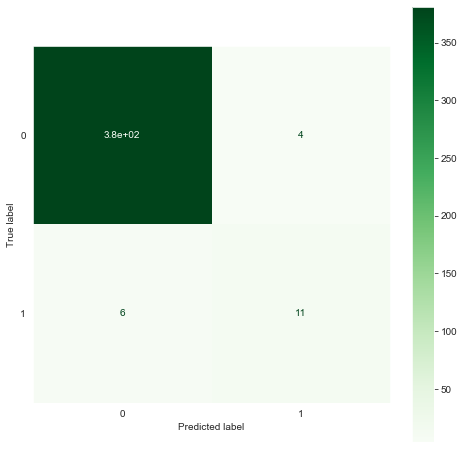

In [63]:
plot_cm(tree_clf)

In [64]:
print_metrics(y_test, dt_pred)

Precision Score: 0.7333333333333333
Recall Score: 0.6470588235294118
Accuracy Score: 0.9751243781094527
F1 Score: 0.6875


The decision tree model was unable to improve upon the results of our previous models.

## Decision Tree with SMOTE

In [65]:
smote_tclf = DecisionTreeClassifier(criterion='gini', max_depth=5)
smote_tclf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [66]:
# Test set predictions
smote_tpred = smote_tclf.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, smote_tpred))
print(classification_report(y_test, smote_tpred))

[[373  12]
 [  6  11]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       385
           1       0.48      0.65      0.55        17

    accuracy                           0.96       402
   macro avg       0.73      0.81      0.76       402
weighted avg       0.96      0.96      0.96       402



In [67]:
smote_tclf.score(X_train_resampled, y_train_resampled)

0.986870897155361

In [68]:
smote_tclf.score(X_test, y_test)

0.9552238805970149

As seems to be the them with SMOTE, it has not increse the accuracy of the model.

## Hyperparameter

Tune the model to find best parameters

In [69]:
model = DecisionTreeClassifier()

dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

# define grid search
grid_dt = GridSearchCV(model, dt_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_dt.fit(X_train, y_train)

best_parameters = grid_dt.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds_dt = grid_dt.predict(X_train)
test_preds_dt = grid_dt.predict(X_test)
training_accuracy_dt = accuracy_score(y_train, training_preds_dt)
test_accuracy_dt = accuracy_score(y_test, test_preds_dt)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy_dt * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy_dt * 100))

Grid Search found the following optimal parameters: 
criterion: 'gini'
max_depth: 4
min_samples_leaf: 2
min_samples_split: 2

Training Accuracy: 99.25%
Testing Accuracy: 98.51%


The model performed well, but not better than our previous models.

## Bagged Trees

Our next Tree model I am going to look at is the Bagged Trees method.

In [70]:
# Instantiate a BaggingClassifier
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20)

In [71]:
# Fit to the training data
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=5,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
   

In [72]:
# Test set predictions
bagged_pred = bagged_tree.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, bagged_pred))
print(classification_report(y_test, bagged_pred))

[[384   1]
 [  6  11]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       385
           1       0.92      0.65      0.76        17

    accuracy                           0.98       402
   macro avg       0.95      0.82      0.87       402
weighted avg       0.98      0.98      0.98       402



In [73]:
# Training accuracy score
bagged_tree.score(X_train, y_train)

0.9968017057569296

In [74]:
# Test accuracy score
bagged_tree.score(X_test, y_test)

0.9825870646766169

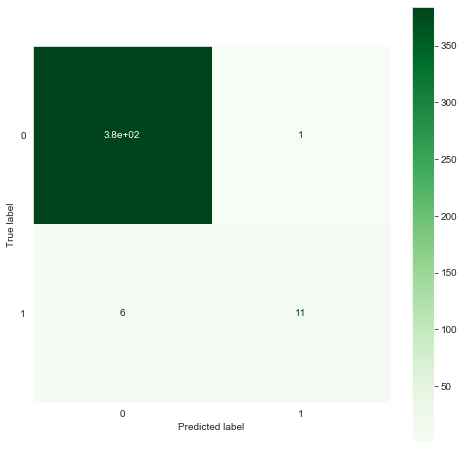

In [75]:
plot_cm(bagged_tree)

This method was very successful and provided the same testing results as the optimized logisitic regression model I ran earlier. Perhaps with some tuning of the hyperparameters I could find a model that outperforms the SVM model but first it's time to look at the obligatory model using SMOTE.

## Bagged Trees with SMOTE

In [76]:
# Instantiate a BaggingClassifier
bagged_smote = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20)
# Fit to the training data
bagged_smote.fit(X_train_resampled, y_train_resampled)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=5,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
   

In [77]:
# Test set predictions
smote_bpred = bagged_smote.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, smote_bpred))
print(classification_report(y_test, smote_bpred))

[[372  13]
 [  2  15]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       385
           1       0.54      0.88      0.67        17

    accuracy                           0.96       402
   macro avg       0.77      0.92      0.82       402
weighted avg       0.98      0.96      0.97       402



In [78]:
print("Testing Accuracy for Bagged Tree Classifier with SMOTE: {:.4}%".format(accuracy_score(y_test, smote_bpred) * 100))

Testing Accuracy for Bagged Tree Classifier with SMOTE: 96.27%


Accuracy decreased significantly.

## Hyperparameter

In [79]:
model = BaggingClassifier()
n_estimators = [10, 100, 1000]
# define grid search
grid = dict(n_estimators=n_estimators)
grid_bag = GridSearchCV(model, param_grid=grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_bag.fit(X_train, y_train)

best_parameters = grid_bag.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_bags = grid_bag.predict(X_train)
test_bags = grid_bag.predict(X_test)
training_accuracy_bags = accuracy_score(y_train, training_bags)
test_accuracy_bags = accuracy_score(y_test, test_bags)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy_bags * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy_bags * 100))

Grid Search found the following optimal parameters: 
n_estimators: 10

Training Accuracy: 99.79%
Testing Accuracy: 98.76%


The original baseline Bagging classifier was the best and unfortunately not accurate enough to replace the SVM model.

## Random Forest

The next model that I will consider is the Random Forest model.

In [80]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth=5)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [81]:
# Training accuracy score
forest.score(X_train, y_train)

0.9968017057569296

In [82]:
# Test accuracy score
forest.score(X_test, y_test)

0.9800995024875622

In [83]:
# Test set predictions
rf_pred = forest.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

[[385   0]
 [  8   9]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       385
           1       1.00      0.53      0.69        17

    accuracy                           0.98       402
   macro avg       0.99      0.76      0.84       402
weighted avg       0.98      0.98      0.98       402



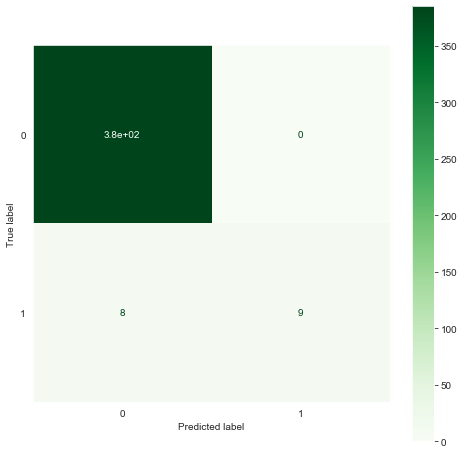

In [84]:
plot_cm(forest)

In [85]:
print_metrics(y_test, rf_pred)

Precision Score: 1.0
Recall Score: 0.5294117647058824
Accuracy Score: 0.9800995024875622
F1 Score: 0.6923076923076924


The Random Forest model appears to be suffering from overfitting and a poor recall score in comparison to the precision score. It misclassified 8 of the players and only correctly classified 10 Hall of Famers. I am going to try to improve the model with SMOTE and hyperparameter tuning.

## Random Forest with SMOTE

In [86]:
# Instantiate and fit a RandomForestClassifier
smote_forest = RandomForestClassifier(n_estimators=100, max_depth=5)
smote_forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [87]:
# Training accuracy score
smote_forest.score(X_train_resampled, y_train_resampled)

0.9917943107221007

In [88]:
# Test accuracy score
smote_forest.score(X_test, y_test)

0.9676616915422885

In [89]:
# Test set predictions
srf_pred = smote_forest.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, srf_pred))
print(classification_report(y_test, srf_pred))

[[376   9]
 [  4  13]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       385
           1       0.59      0.76      0.67        17

    accuracy                           0.97       402
   macro avg       0.79      0.87      0.82       402
weighted avg       0.97      0.97      0.97       402



In [90]:
print_metrics(y_test, srf_pred)

Precision Score: 0.5909090909090909
Recall Score: 0.7647058823529411
Accuracy Score: 0.9676616915422885
F1 Score: 0.6666666666666667


Unfortunately, SMOTE once again decrease the accuracy of the model.

## Hyperparameter Tuning

In [91]:
model = RandomForestClassifier()

rf_param_grid = {
    'n_estimators': [10, 100, 1000],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

# define grid search
grid_rf = GridSearchCV(model, rf_param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_rf.fit(X_train, y_train)

best_parameters = grid_rf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds_rf = grid_rf.predict(X_train)
test_preds_rf = grid_rf.predict(X_test)
training_accuracy_rf = accuracy_score(y_train, training_preds_rf)
test_accuracy_rf = accuracy_score(y_test, test_preds_rf)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy_rf * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy_rf * 100))

Grid Search found the following optimal parameters: 
criterion: 'entropy'
max_depth: None
max_features: 'log2'
min_samples_leaf: 3
min_samples_split: 10
n_estimators: 10

Training Accuracy: 99.15%
Testing Accuracy: 97.76%


The Random Forest model was not improved and therefore is not the best model for this analysis.

# Extreme Gradient Boosting

The last model I will test is the XGB boosting model.

In [92]:
# Instantiate XGBClassifier
clf = XGBClassifier()

# Fit XGBClassifier
clf.fit(X_train, y_train)

# Predict on training and test sets
training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 100.0%
Testing Accuracy: 98.01%


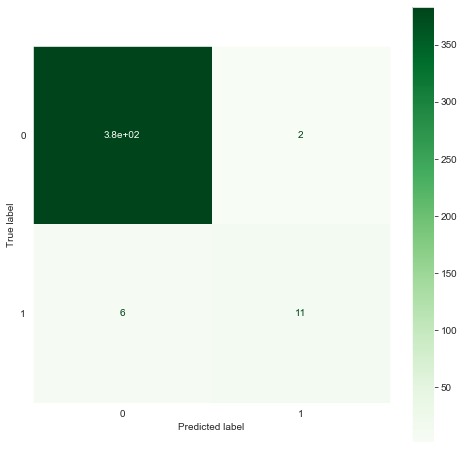

In [93]:
plot_cm(clf)

This model had great training accuracy but struggled did not perform to that same standard with the testing accuracy. I will tune the hyperparameters to see if this model can be improved or if the SVM model is in fact the best for this analysis.

## Hyperparameter Tuning

In [94]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7, 1],
    'n_estimators': [10, 100, 1000],
}

In [95]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 3
min_child_weight: 2
n_estimators: 100
subsample: 0.7

Training Accuracy: 99.68%
Testing Accuracy: 98.01%


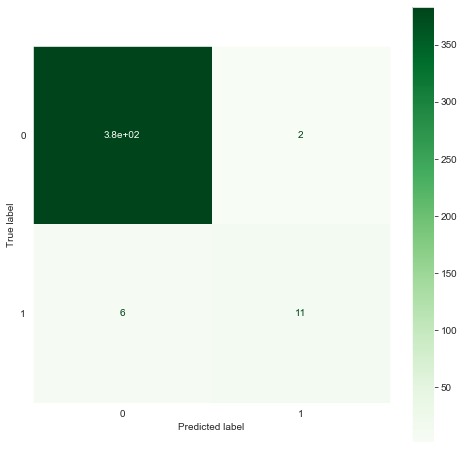

In [96]:
plot_cm(grid_clf)

This model perfomed similiarly to the base XGB model and did not outperform the SVM model which means that I am going to move forward with the SVM model to see if I can make any further changes to improve that model's performance.

# Model Optimization and Evaluation

Although there were a few good options such as Logisitic Regression and Bagging, the SVM model outperformed the others. This model has been tuned using an array of hyperparameters to find what works best; however, it might benefit the model to log transform the features. Due to the fact that there are several zeros in the dataset I will do log + 1 in order to work around that. The last thing I want to look at is the feature importance to determine if there are any that can be dropped for improved model performance. It is going to be tough to outperform the optimized model but it will be interesting to see if it is possible!

In [97]:
# Run log function for the features.
log_features = X.columns
log_transform(X, log_features)

,Seasons,W,G,SV,SO,ERA,WHIP,K/9,K/BB,BAA,...,K/9_log,K/BB_log,BAA_log,FP_log,Cy Young_log,Gold Glove_log,Most Valuable Player_log,Rolaids Relief Man Award_log,Rookie of the Year_log,ASG_log
0,13,66,448,82,641,3.80,1.39,5.20,1.40,0.259,...,1.824549,0.875469,0.230318,0.662688,0.0,0.0,0.0,0.0,0.0,0.693147
1,12,62,248,0,484,4.39,1.37,3.39,1.38,0.280,...,1.479329,0.867100,0.246860,0.667829,0.0,0.0,0.0,0.0,0.0,0.000000
2,11,87,263,0,888,4.25,1.43,4.77,1.43,0.276,...,1.752672,0.887891,0.243730,0.683097,0.0,0.0,0.0,0.0,0.0,0.000000
3,12,43,162,0,496,4.92,1.49,6.19,1.26,0.250,...,1.972691,0.815365,0.223144,0.672944,0.0,0.0,0.0,0.0,0.0,0.000000
4,17,63,681,148,765,3.46,1.40,6.00,1.29,0.235,...,1.945910,0.828552,0.211071,0.667829,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,14,111,304,1,705,3.74,1.35,3.43,1.34,0.278,...,1.488400,0.850151,0.245296,0.667829,0.0,0.0,0.0,0.0,0.0,0.000000
1338,12,132,354,0,1637,3.66,1.33,7.52,1.82,0.236,...,2.142416,1.036737,0.211880,0.667829,0.0,0.0,0.0,0.0,0.0,1.386294
1339,10,43,250,8,207,3.54,1.35,2.00,0.69,0.262,...,1.098612,0.524729,0.232698,0.683097,0.0,0.0,0.0,0.0,0.0,0.000000
1340,12,43,224,6,383,4.28,1.57,4.39,0.82,0.255,...,1.684545,0.598837,0.227136,0.672944,0.0,0.0,0.0,0.0,0.0,0.000000


In [98]:
# Drop all of the original features as to keep only the log transformations.
X_log = X.drop(columns=['Seasons', 'W', 'G', 'SV', 'SO', 'ERA', 'WHIP', 'K/9', 'K/BB', 'BAA', 'FP', 
                        'Cy Young', 'Gold Glove', 'Most Valuable Player', 
                        'Rolaids Relief Man Award', 'Rookie of the Year', 'ASG'], axis=1)
X_log.head()

,Seasons_log,W_log,G_log,SV_log,SO_log,ERA_log,WHIP_log,K/9_log,K/BB_log,BAA_log,FP_log,Cy Young_log,Gold Glove_log,Most Valuable Player_log,Rolaids Relief Man Award_log,Rookie of the Year_log,ASG_log
0,2.639057,4.204693,6.107023,4.418841,6.464588,1.568616,0.871293,1.824549,0.875469,0.230318,0.662688,0.0,0.0,0.0,0.0,0.0,0.693147
1,2.564949,4.143135,5.517453,0.000000,6.184149,1.684545,0.862890,1.479329,0.867100,0.246860,0.667829,0.0,0.0,0.0,0.0,0.0,0.000000
2,2.484907,4.477337,5.575949,0.000000,6.790097,1.658228,0.887891,1.752672,0.887891,0.243730,0.683097,0.0,0.0,0.0,0.0,0.0,0.000000
3,2.564949,3.784190,5.093750,0.000000,6.208590,1.778336,0.912283,1.972691,0.815365,0.223144,0.672944,0.0,0.0,0.0,0.0,0.0,0.000000
4,2.890372,4.158883,6.525030,5.003946,6.641182,1.495149,0.875469,1.945910,0.828552,0.211071,0.667829,0.0,0.0,0.0,0.0,0.0,0.000000


In [99]:
# Train the data.
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y, test_size=.30, random_state=42)

# Print the info.
print("X_train shape:", X_train_log.shape, "| X_test shape:", X_test_log.shape)
print("y_train mean:", round(np.mean(y_train_log),2), "| y_test mean:", round(np.mean(y_test_log),2))
print(X_train_log.shape[1], "features:", X_train_log.columns.to_list())

X_train shape: (938, 17) | X_test shape: (402, 17)
y_train mean: 0.03 | y_test mean: 0.04
17 features: ['Seasons_log', 'W_log', 'G_log', 'SV_log', 'SO_log', 'ERA_log', 'WHIP_log', 'K/9_log', 'K/BB_log', 'BAA_log', 'FP_log', 'Cy Young_log', 'Gold Glove_log', 'Most Valuable Player_log', 'Rolaids Relief Man Award_log', 'Rookie of the Year_log', 'ASG_log']


In [100]:
# Run the hyperparameter search on the log transformed features.

model = SVC()
kernel = ['linear']
C = [.0001, .001, .01, 1]
gamma = [.001, .01, 1]
grid = dict(kernel=kernel,C=C,gamma=gamma)
grid_svc_log = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_svc_log.fit(X_train_log, y_train_log)

best_parameters = grid_svc_log.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds_log = grid_svc_log.predict(X_train_log)
test_preds_log = grid_svc_log.predict(X_test_log)
training_accuracy_log = accuracy_score(y_train_log, training_preds_log)
test_accuracy_log = accuracy_score(y_test_log, test_preds_log)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy_log * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy_log * 100))

Grid Search found the following optimal parameters: 
C: 1
gamma: 0.001
kernel: 'linear'

Training Accuracy: 98.93%
Testing Accuracy: 97.76%


Unfortunately, a log transformation of the features did not result in a boosted model performance. One last effort to improve my model is going to come from analyzing the feature importance. Perhaps dropping some of the least important features will have a positive impact. 

In [101]:
# Use the optimized parameters for the model and fit it to our training data.
svm = SVC(gamma=0.001, C=1, kernel = 'linear')
svm.fit(X_train, y_train)

# Define the model features.
model_features = ['Seasons', 'W', 'G', 'SV', 'SO', 'ERA', 'WHIP', 'K/9', 'K/BB', 'BAA',
       'FP', 'Cy Young', 'Gold Glove', 'Most Valuable Player',
       'Rolaids Relief Man Award', 'Rookie of the Year', 'ASG']

# Create a dictionary of features and accompanying coefficients.
coef_dict = {}
for coef, feat in zip(abs(svm.coef_[0,:]),model_features):
    coef_dict[feat] = coef
coef_dict

{'Seasons': 0.20719916835268748,
 'W': 0.016791483238648652,
 'G': 0.0017209398526460973,
 'SV': 0.007165895971638747,
 'SO': 7.712384922342608e-05,
 'ERA': 1.1769213035886836,
 'WHIP': 0.17756043039926706,
 'K/9': 0.31186199503855416,
 'K/BB': 0.48806393634318557,
 'BAA': 0.02079725610919131,
 'FP': 0.03470093516694994,
 'Cy Young': 1.1610225281892488,
 'Gold Glove': 0.05823589743552321,
 'Most Valuable Player': 0.17223424615533167,
 'Rolaids Relief Man Award': 0.31887260414957286,
 'Rookie of the Year': 0.0,
 'ASG': 0.35534136623853163}

In [102]:
# Transform the dictionary to a DataFrame in order to visualize.
feature_df = pd.DataFrame.from_dict(coef_dict, orient='index').reset_index()
feature_df.columns = ['Features', 'Coefs']
feature_df = feature_df.sort_values(by='Coefs', ascending=False)
feature_df

,Features,Coefs
5,ERA,1.176921
11,Cy Young,1.161023
8,K/BB,0.488064
16,ASG,0.355341
14,Rolaids Relief Man Award,0.318873
7,K/9,0.311862
0,Seasons,0.207199
6,WHIP,0.177560
13,Most Valuable Player,0.172234
12,Gold Glove,0.058236


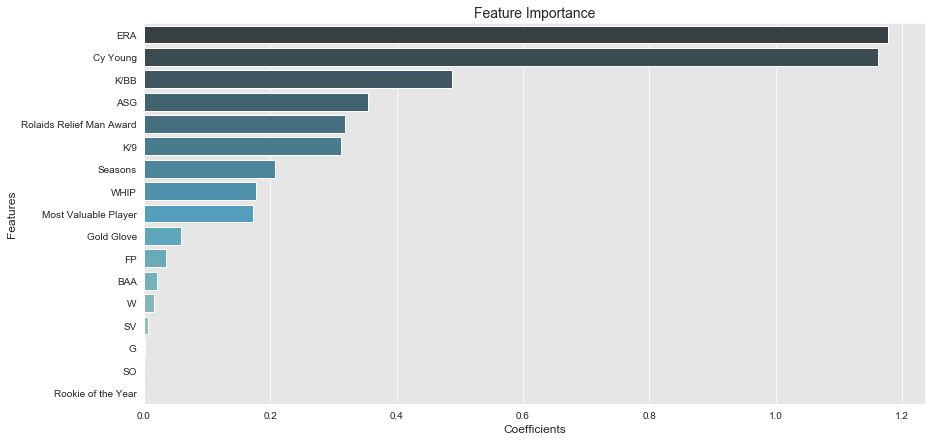

In [103]:
#Plot the above findings.
plt.figure(figsize=(14,7))
ax4 = sns.barplot(x=feature_df['Coefs'], y=feature_df['Features'], palette='GnBu_d')
plt.xlabel('Coefficients', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance', fontsize=14)
plt.savefig('FeatureImportance');

I am going to drop the bottom three features to see if it improves our model performance.

In [105]:
# Drop all of the original features as to keep only the log transformations.
X_1 = X.drop(columns=['Seasons_log', 'W_log', 'G_log', 'SV_log', 'SO_log', 'ERA_log', 'WHIP_log', 'K/9_log', 
                       'K/BB_log', 'BAA_log', 'FP_log', 'Cy Young_log', 'Gold Glove_log', 
                       'Most Valuable Player_log', 'Rolaids Relief Man Award_log', 'Rookie of the Year_log', 
                       'ASG_log', 'G', 'SO', 'Rookie of the Year'], axis=1)
X_1.head()

,Seasons,W,SV,ERA,WHIP,K/9,K/BB,BAA,FP,Cy Young,Gold Glove,Most Valuable Player,Rolaids Relief Man Award,ASG
0,13,66,82,3.80,1.39,5.20,1.40,0.259,0.94,0.0,0.0,0.0,0.0,1.0
1,12,62,0,4.39,1.37,3.39,1.38,0.280,0.95,0.0,0.0,0.0,0.0,0.0
2,11,87,0,4.25,1.43,4.77,1.43,0.276,0.98,0.0,0.0,0.0,0.0,0.0
3,12,43,0,4.92,1.49,6.19,1.26,0.250,0.96,0.0,0.0,0.0,0.0,0.0
4,17,63,148,3.46,1.40,6.00,1.29,0.235,0.95,0.0,0.0,0.0,0.0,0.0


In [106]:
# Train the data.
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y, test_size=.30, random_state=42)

# Print the info.
print("X_train shape:", X_train_1.shape, "| X_test shape:", X_test_1.shape)
print("y_train mean:", round(np.mean(y_train_1),2), "| y_test mean:", round(np.mean(y_test_1),2))
print(X_train_1.shape[1], "features:", X_train_1.columns.to_list())

X_train shape: (938, 14) | X_test shape: (402, 14)
y_train mean: 0.03 | y_test mean: 0.04
14 features: ['Seasons', 'W', 'SV', 'ERA', 'WHIP', 'K/9', 'K/BB', 'BAA', 'FP', 'Cy Young', 'Gold Glove', 'Most Valuable Player', 'Rolaids Relief Man Award', 'ASG']


In [107]:
# Run the hyperparameter search on the new list of features.
model = SVC()
kernel = ['linear']
C = [.0001, .001, .01, 1]
gamma = [.001, .01, 1]
grid = dict(kernel=kernel,C=C,gamma=gamma)
grid_svc_1 = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_svc_1.fit(X_train_1, y_train_1)

best_parameters = grid_svc_1.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds_1 = grid_svc_1.predict(X_train_1)
test_preds_1 = grid_svc_1.predict(X_test_1)
training_accuracy_1 = accuracy_score(y_train_1, training_preds_1)
test_accuracy_1 = accuracy_score(y_test_1, test_preds_1)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy_1 * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy_1 * 100))

Grid Search found the following optimal parameters: 
C: 0.01
gamma: 0.001
kernel: 'linear'

Training Accuracy: 99.04%
Testing Accuracy: 98.26%


Dropping those 3 less significant features did not have the desired impact on our model that we had hoped for, at this point I am satisfied with the optimized SVM model we created earlier. Due to the nature of Hall of Fame voting which is subjected to the opinion of Baseball writers voting on a game that has greatly changed over the century there is always going to be room for a few inaccurate predictions. Let's take one last look at the key metrics of our SVM model and make recommendations based on those.

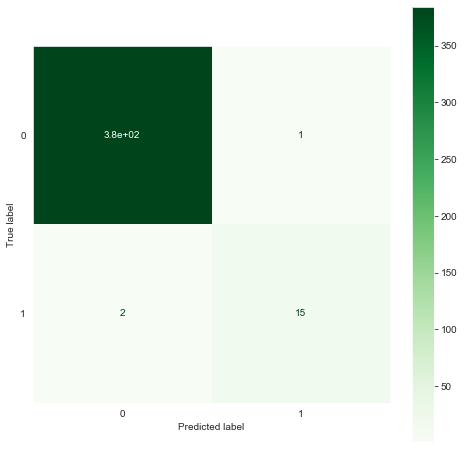

In [108]:
plot_cm(grid_svc)

In [114]:
print_metrics(y_test, test_preds_svc)

Precision Score: 0.9375
Recall Score: 0.8823529411764706
Accuracy Score: 0.9925373134328358
F1 Score: 0.9090909090909091


As mentioned earlier, it's worth considering whether a high precision score is better than a high recall score in this scenario. For this analysis I did not weigh either heavier than the other. If I would have decided precision score was more important in this analysis, it would have made more sense for me to choose the Logisitic Regression model or the Bagging model. Both of these models had perfect precision but worse recall than the SVM model. The reason for my decision is that the Hall of Fame is a highly respected institution and allowing too many players in who do not deserve it could water down the achievement of the other members. On the other hand, a player's career achievements are the output of a lifetime of work and leaving someone out who deserves to be in could damage not only the player's reputation but also the BBWA voters. For this reason I decided to put equal weight on the two. Now that the final model has been decided upon, it's time for recommendations to the BBWA voters and future work.

# Recommendations

When considering who should be inducted in the Major League Baseball Hall of Fame, I would recommend the following:

1. When analyzing the past performances in order to make a decision on future inductees, remove those individuals who have not been elected due to non-performance related issues such as Performance Enhancing Drugs and scandals detrimental to the sport.
2. When reviewing a player, some of the key areas to focus on should be ERA, Cy Young Awards, Strikout to Walk ratio and All-Star game appearances. There are several others but when analyzing what has had the most impact on voting in the past, those features were most predominant.
3. Take into consideration which is more important, that there are no individuals who deserve to be in the Hall of Fame left out, that no one who doesn't deserve be let in or perhaps a combination of both. It is my recommendation that neither is more important than the other.
4. It is important when considering a player for induction that not too much emphasis be placed on two sets of statistics that are highly correlated, otherwise it'll give additional the value to each.
5. Although fielding is an important part of the game, most of the value of a Hall of Famer comes from the pitching or hitting statistics and to stay consistent with past voting should carry most of the weight.

# Future Work

There are several other considerations that I would like to make in the future.

1. Consider all Hall of Fame inductees, not just those voted in by the Baseball Writers of America.
2. Further analyze how position impacts the Hall of Fame voting, for instance a catcher should be compared to other catchers rather than all position players.
3. Which players who have currently played at least ten seasons and have not yet been eligible for HOF voting are likely to be elected based on the analysis.